In [1]:
!pip install pillow

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Importing Libraries

In [2]:
import pydicom
import os
from glob import glob

import numpy as np
import pandas as pd

from matplotlib import cm
from matplotlib import pyplot as plt
import cv2

import tensorflow as tf

from tensorflow import keras 
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
import keras

import seaborn as sns
from tqdm import tqdm
import pylab as pl

#plotly offline imports
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import tools
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis
init_notebook_mode()

### Checking for CPU Count 

In [3]:
import multiprocessing
multiprocessing.cpu_count()

2

### Checking for GPU availability 

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.3.1
Default GPU Device: /device:GPU:0


# <a id = 'section3'> 3. Loading Dataset </font> </a>

In [5]:
# loading rles files
rles_df = pd.read_csv('../input/siim-train-test-2/train-rle.csv')

# the second column just has a space at the start, so giving it a column name
rles_df.columns = ['ImageId', 'EncodedPixels']

In [6]:
rles_df.head()

ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...   
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.11028.15178752...   
3  1.2.276.0.7230010.3.1.4.8323329.10366.15178752...   
4  1.2.276.0.7230010.3.1.4.8323329.10016.15178752...   

                                       EncodedPixels  
0                                                 -1  
1  557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...  
2                                                 -1  
3  514175 10 1008 29 994 30 993 32 991 33 990 34 ...  
4  592184 33 976 58 956 73 941 88 926 102 917 109...

In [7]:
rles_df.shape

(12954, 2)

In [8]:
# Load full training and test sets
train_imgs = sorted(glob('../input/siim-train-test-2/dicom-images-train/*/*/*.dcm'))
test_imgs = sorted(glob('../input/siim-train-test-2/dicom-images-test/*/*/*.dcm'))

print('The training set contains {} files.'.format(len(train_imgs)))
print('The test set contains {} files.'.format(len(test_imgs)))

The training set contains 12089 files.
The test set contains 3205 files.


### Loading RLE File

In [9]:
with_pneumothorax = rles_df[rles_df['EncodedPixels'] != '-1']['EncodedPixels'].count()
without_pneumothorax = rles_df[rles_df['EncodedPixels'] == '-1']['EncodedPixels'].count() # note that the name of the column starts with a space 0_o

print('There are {} samples with pneumothorax in training set.'.format(with_pneumothorax))
print('There are {} samples without pneumothorax in training set.'.format(without_pneumothorax))

There are 3576 samples with pneumothorax in training set.
There are 9378 samples without pneumothorax in training set.


# <a id = 'section4'> 4. EDA </font> </a>

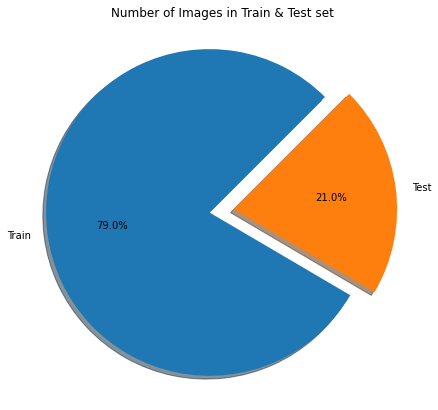

In [10]:
# Data to plot
labels = 'Train', 'Test'
sizes = [12089, 3205]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.15, 0)  # explode 1st slice

# Plot
fig, ax = plt.subplots(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, 
autopct='%1.1f%%', shadow=True, startangle=45)

plt.axis('equal')
plt.title('Number of Images in Train & Test set')
plt.show()

1. By loading the train & test set we notice that there are 12089 images in the training set & 3205 images in the test set.


2. From the pie chart above we can observe that the training set comprises of 79% of the total data & the test set is 21%.

### Plotting some random images from the provided dataset

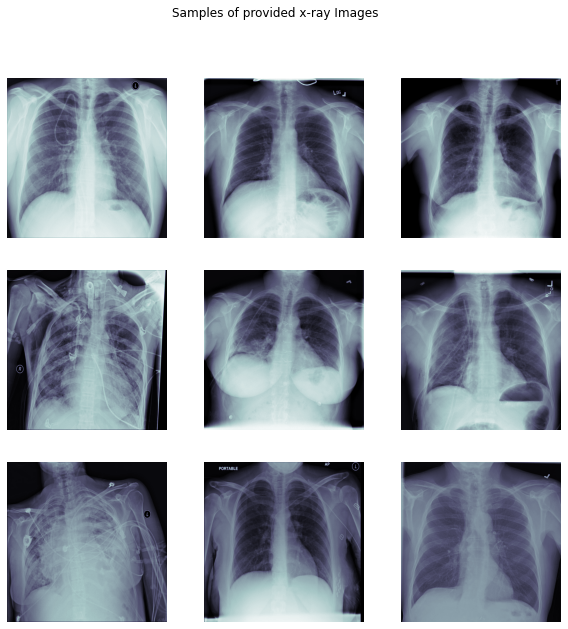

In [11]:
# Plot 9 random images from training dataset
fig, axs = plt.subplots(3, 3, figsize=(10,10))
    
for im in range(9):
    i = im // 3
    j = im % 3

    # choose random images from train set
    fn = np.random.choice(train_imgs)
    img = pydicom.read_file(fn).pixel_array

    #plot the data
    axs[i,j].imshow(img, cmap='bone')
    axs[i,j].axis('off')
        
# set suptitle
plt.suptitle('Samples of provided x-ray Images')
plt.show()

From the above images we can observe :-

1. It is very diffcult to identify Pnuemothorax just by visual inspection by an average person.


2. A medical expert with years of experience might be able to spot pneumothorax just by visual inspection. 


3. There are no distinctive visual features to identify presence of Pneumothorax in the plotted x-ray images.


4. All the X-ray images look quite identical to each other.


5. The images seem to be at varying scales and rotations, it could be beneficial to isolate the lung area using a separate algorithm and remove the rest of the image.


6. Some of the training images seem poor in quality, I have noticed multiple training images that look like this. One of the images was upside down. Augmentation should hopefully help with this, additional analysis of the rate of pneumo positive images that are distorted could be helpful.

### Extracting info from the DCM Files 

In [12]:
"This function parses DICOM dataset and returns a dictonary with relevant fields"

"""

    Args:
        dicom_data (dicom): chest x-ray data in dicom format.
        file_path (str): file path of the dicom data.
        rles_df (pandas.core.frame.DataFrame): Pandas dataframe of the RLE.
        encoded_pixels (bool): if True we will search for annotation.
        
    Returns:
        dict: contains metadata of relevant fields.
"""

def dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=True):
   
    data = {}
    
    # Parse fields with meaningful information
    data['patient_name'] = dicom_data.PatientName
    data['patient_id'] = dicom_data.PatientID
    data['patient_age'] = int(dicom_data.PatientAge)
    data['patient_sex'] = dicom_data.PatientSex
    data['pixel_spacing'] = dicom_data.PixelSpacing
    data['file_path'] = file_path
    data['id'] = dicom_data.SOPInstanceUID
    
    
    if encoded_pixels:
        encoded_pixels_list = rles_df[rles_df['ImageId']==dicom_data.SOPInstanceUID]['EncodedPixels'].values
       
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != '-1':
                pneumothorax = True
        
        # get meaningful information (for train set)
        data['encoded_pixels_list'] = encoded_pixels_list
        data['has_pneumothorax'] = pneumothorax
        data['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return data

In [13]:
# parse train DICOM dataset
train_meta_df = pd.DataFrame()
train_meta_list = []
for file_path in tqdm(train_imgs):
    dicom_data = pydicom.dcmread(file_path)
    train_meta = dicom_to_dict(dicom_data, file_path, rles_df)
    train_meta_list.append(train_meta)
train_meta_df = pd.DataFrame(train_meta_list)

100%|██████████| 12089/12089 [02:34<00:00, 78.40it/s]


In [14]:
# parse test DICOM dataset
test_meta_df = pd.DataFrame()
test_meta_list = []
for file_path in tqdm(test_imgs):
    dicom_data = pydicom.dcmread(file_path)
    test_meta = dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=False)
    test_meta_list.append(test_meta)
test_meta_df = pd.DataFrame(test_meta_list)

100%|██████████| 3205/3205 [00:34<00:00, 93.70it/s]


In [15]:
train_meta_df.head()

patient_name  \
0  (1, 7, d, 4, 0, 5, a, 3, -, a, 0, d, 2, -, 4, ...   
1  (8, a, b, 1, f, f, d, a, -, 8, b, 6, 5, -, 4, ...   
2  (b, f, e, f, 5, 1, d, 3, -, 6, 5, 4, 1, -, 4, ...   
3  (d, 1, 9, d, 9, 5, 6, f, -, 4, d, d, d, -, 4, ...   
4  (c, f, 7, 1, a, 7, 6, 0, -, f, 6, 9, 3, -, 4, ...   

                             patient_id  patient_age patient_sex  \
0  17d405a3-a0d2-4901-b33a-63906aa48d9f           38           M   
1  8ab1ffda-8b65-4914-95d6-2e549e328666           10           F   
2  bfef51d3-6541-4792-bac1-d21d41ee60fd           50           F   
3  d19d956f-4ddd-4688-81ff-909c85e0e2d9           68           F   
4  cf71a760-f693-4ccf-acd4-a41ff4845a5f           65           M   

    pixel_spacing                                          file_path  \
0  [0.168, 0.168]  ../input/siim-train-test-2/dicom-images-train/...   
1  [0.139, 0.139]  ../input/siim-train-test-2/dicom-images-train/...   
2  [0.168, 0.168]  ../input/siim-train-test-2/dicom-images-train/...   
3  [0.139, 0.139]  ../input/siim-train-test-2/dicom-images-train/...   
4  [0.168, 0.168]  ../input/siim-train-test-2/dicom-images-train/...   

                                                  id encoded_pixels_list  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...                [-1]   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...                [-1]   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...                [-1]   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...                [-1]   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...                [-1]   

   has_pneumothorax  encoded_pixels_count  
0             False                     1  
1             False                     1  
2             False                     1  
3             False                     1  
4             False                     1

In [16]:
# print missing annotation
missing_vals = train_meta_df[train_meta_df['encoded_pixels_count']==0]['encoded_pixels_count'].count()
print("Number of x-rays with missing labels: {}".format(missing_vals))

Number of x-rays with missing labels: 42


In [17]:
nok_count = train_meta_df['has_pneumothorax'].sum()
ok_count = len(train_meta_df) - nok_count
x = ['No Pneumothorax','Pneumothorax']
y = [ok_count, nok_count]
trace0 = Bar(x=x, y=y, name = 'Ok vs Not OK')
nok_encoded_pixels_count = train_meta_df[train_meta_df['has_pneumothorax']==1]['encoded_pixels_count'].values
trace1 = Histogram(x=nok_encoded_pixels_count, name='# of annotations')
fig = tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=400, width=900, title='Pneumothorax Instances')
iplot(fig)

/opt/conda/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



1. Compared to the number of patients without Pneumothorax we have less number of patients with Pneumothorax.


2. There are 42 instances of X-Ray without any annotations.


3. For most X-Rays there are only one mask / area that has label.


4. But there are still many X-Rays which have more than one region where you can observe Pneumothorax.


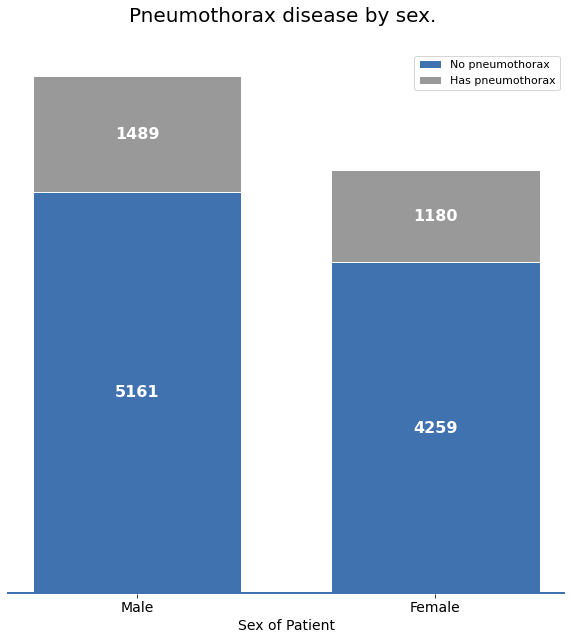

In [18]:
male_train = train_meta_df[train_meta_df['patient_sex'] == 'M']
female_train = train_meta_df[train_meta_df['patient_sex'] == 'F']

male_negative = len(male_train[male_train['has_pneumothorax'] == 0])
female_negative = len(female_train[female_train['has_pneumothorax'] == 0])
male_positive = len(male_train[male_train['has_pneumothorax'] == 1])
female_positive = len(female_train[female_train['has_pneumothorax'] == 1])

r = [0, 1]
barWidth = 0.7
x_labels = ["Male", "Female"]

bar1 = [male_negative, female_negative]
bar2 = [male_positive, female_positive]
bar_height = np.add(bar1, bar2).tolist()

fig = plt.figure(figsize = (10, 10))
b1 = plt.bar(r, bar1, color = '#3f72af', edgecolor = 'white', width = barWidth)
b2 = plt.bar(r, bar2, bottom = bar1, color = '#999999', edgecolor = 'white', width = barWidth)
plt.xticks(r, x_labels, fontsize = 14)
plt.yticks([])
plt.xlabel("Sex of Patient", fontsize = 14)
plt.legend(loc = 'upper right', labels = ['No pneumothorax', 'Has pneumothorax'], fontsize = 11)
plt.title('Pneumothorax disease by sex. \n', fontsize = 20)
plt.box(on = None)
plt.ylim(0,)
plt.axhline(y = 0, linewidth = 5, color = '#3f72af')

for a, b in zip(b1, b2):
    h1 = a.get_height()
    h2 = b.get_height()
    plt.text(a.get_x() + a.get_width() / 2, h1 / 2, h1, horizontalalignment="center", 
             verticalalignment = "center", color = "white", fontsize = 16, fontweight = "bold")
    plt.text(b.get_x() + b.get_width() / 2, h1 + h2 / 2, h2, verticalalignment = "center", 
             horizontalalignment = "center", color = "white", fontsize = 16, fontweight = "bold")

plt.show()

1. There are more number of male patients than female ones in the provided dataset.


2. There are total of 6650 & 5439 male & femaile patients respectively.


3. At first glance we observe that the number of male patients with positive Pneumothorax is more than the female patients.


4. But if we calculate the actual percentage of positive cases for each gender then there are 22.39% of male patients are positive while 21.69% of female patients are positive.

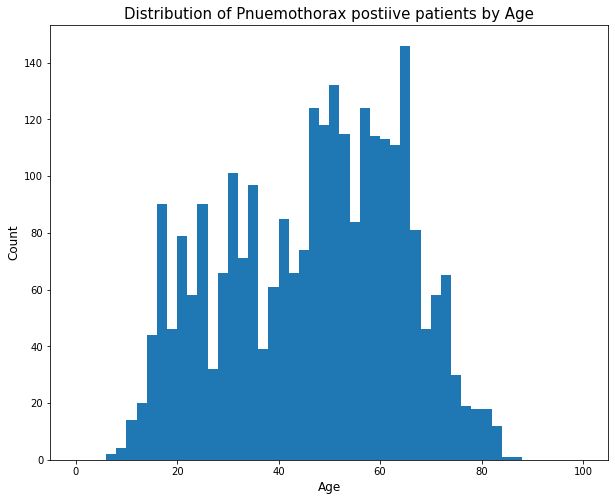

In [19]:
pneumo_pos_age = train_meta_df[train_meta_df['has_pneumothorax']==1]['patient_age'].values
plt.figure(figsize=(10,8))
plt.hist(pneumo_pos_age, bins = 50, range=[0, 100])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.title('Distribution of Pnuemothorax postiive patients by Age', fontsize = 15) 
plt.show()

From the above we can observe the following :-


1. Pnuemothorax is not observed in infants. 


2. We see very few cases of Pneumothorax among childrens till age 10.


3. The number of cases show slight increase among teens.


4. While a drastic increase in the number of cases are found for patients aged 18-20.


5. There are close to 100 patients aged 30.


6. The graph shows a downward trend moving to person aged 40 which later again shows a upward trend moving past 40.


7. Maximum number of patients are found within the range of 50-65 years of old with 120-150 patients.


8. Beyond 65 years of age we observe the number of patients come down to around 60.


9. The cases for people above age 80 are close to 10.

#### Lets divide the pateints into 4 groups according to their age to check which group has more Pneumothorax pateints 

In [20]:
# Discrete ages
"This function takes age as input and return age category"

def age_categories(age):
    
    if age <= 14:
        return 'Child'
    if age >= 15 and age <= 24:
        return 'Youth'
    if age >= 25 and age <= 64:
        return 'Adult'
    if age >= 65:
        return 'Senior'

# get age categories
train_meta_df['age_category'] = train_meta_df['patient_age'].apply(age_categories)

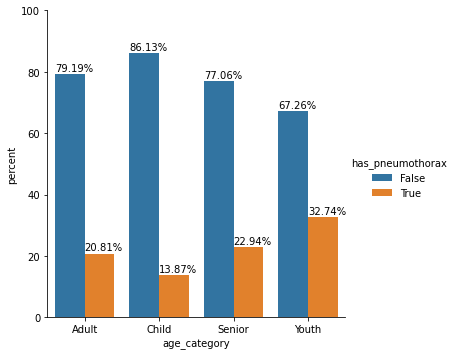

In [21]:
# Male-Female analysis
x, y = 'age_category', 'has_pneumothorax'
df1 = train_meta_df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height() + 1
    g.ax.text(txt_x, txt_y, txt)

1. The above plot shows the percentage of patients in each age category who are suffering with Pnuemothorax. 


2. The least number of cases are found in children with just 13.87% of childrens having Pneumothorax. 


3. This is followed by Adults who have 20.81% of Pneumothorax positive patients.


4. Seniors just have a little difference compared to adults with 22.94% of patients being positive.


5. The maximum percentage of positive patients are found in the Youth category with a percentage count of 32.74%.

# Creating Bounding Boxes around Pneumothorax

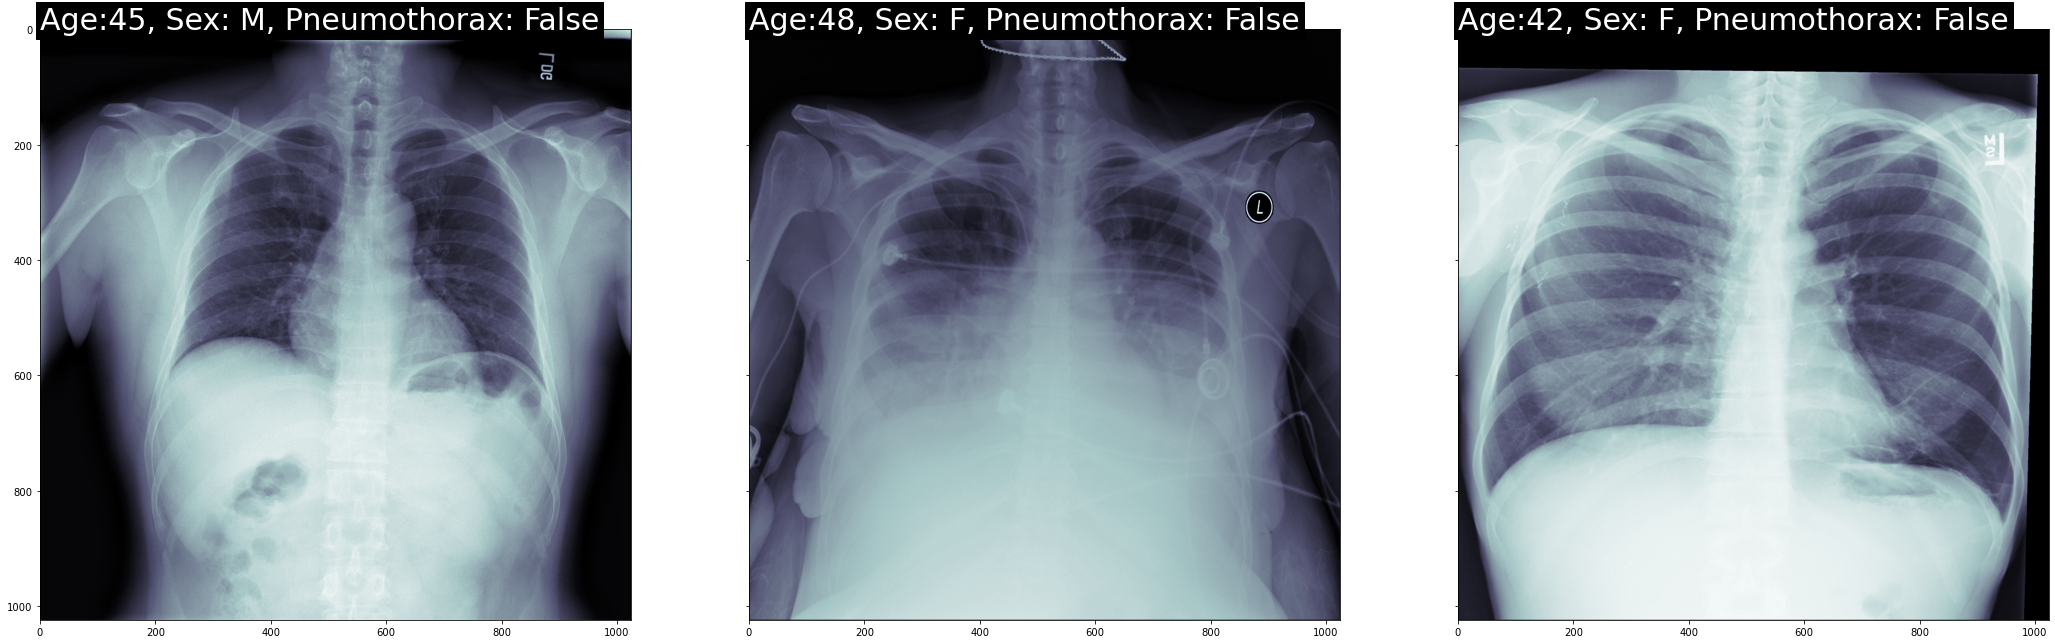

In [22]:
import matplotlib.pyplot as plt
from matplotlib import patches as patches

num_img = 3
subplot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*12,12))
for index, row in train_meta_df.sample(n=num_img).iterrows():
    dataset = pydicom.dcmread(row['file_path'])
    ax[subplot_count].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    # label the x-ray with information about the patient
    ax[subplot_count].text(0,0,'Age:{}, Sex: {}, Pneumothorax: {}'.format(row['patient_age'],row['patient_sex'],row['has_pneumothorax']),
                           size=30,color='white', backgroundcolor='black')
    subplot_count += 1

In [23]:
"This funrtion returns the max & min of a mask to draw bounding box"

def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmin, rmax, cmin, cmax

In [24]:
""

def rle2mask(rle, width, height):
    
    mask= np.zeros(width* height)
    if rle == ' -1' or rle == '-1':
        return mask.reshape(width,height)
    array = np.asarray([int(x) for x in rle.split()])
    
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [25]:
"This function plots Chest Xray image with mask(annotation or label) and without mask."

def plot_with_mask_and_bbox(file_path, mask_encoded_list, figsize=(20,10)):
    
    import cv2
    
    """

    Args:
        file_path (str): file path of the dicom data.
        mask_encoded (numpy.ndarray): Pandas dataframe of the RLE.
        
    Returns:
        plots the image with and without mask.
        
    """
    
    pixel_array = pydicom.dcmread(file_path).pixel_array
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    clahe_pixel_array = clahe.apply(pixel_array)
    
    # use the masking function to decode RLE
    mask_decoded_list = [rle2mask(mask_encoded, 1024, 1024).T for mask_encoded in mask_encoded_list]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,10))
    
    # print out the xray
    ax[0].imshow(pixel_array, cmap=plt.cm.bone)
    # print the bounding box
    for mask_decoded in mask_decoded_list:
        # print out the annotated area
        ax[0].imshow(mask_decoded, alpha=0.3, cmap="Reds")
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(bbox)
    ax[0].set_title('With Mask')
    
    # plot image with clahe processing with just bounding box and no mask
    ax[1].imshow(clahe_pixel_array, cmap=plt.cm.bone)
    for mask_decoded in mask_decoded_list:
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(bbox)
    ax[1].set_title('Without Mask - Clahe')
    
    # plot plain xray with just bounding box and no mask
    ax[2].imshow(pixel_array, cmap=plt.cm.bone)
    for mask_decoded in mask_decoded_list:
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
        ax[2].add_patch(bbox)
    ax[2].set_title('Without Mask')
    plt.show()

image id: 1.2.276.0.7230010.3.1.4.8323329.11425.1517875232.878035


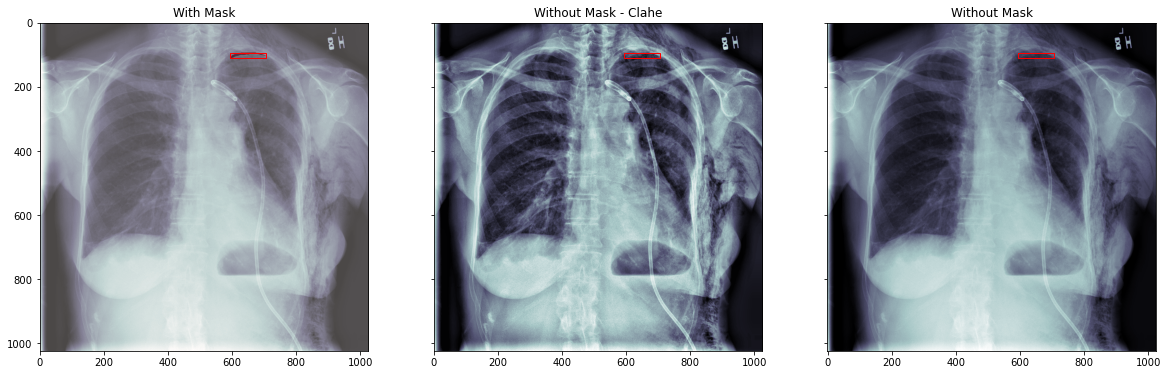

image id: 1.2.276.0.7230010.3.1.4.8323329.13074.1517875243.428265


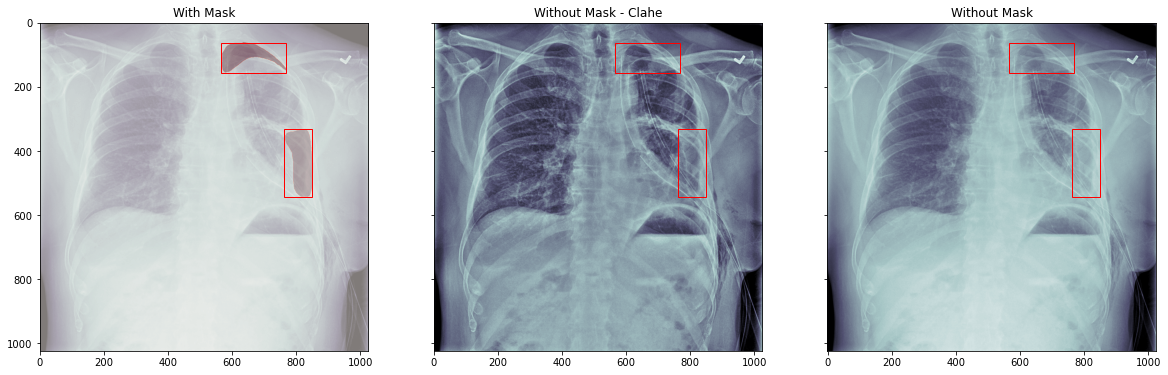

image id: 1.2.276.0.7230010.3.1.4.8323329.3590.1517875178.591002


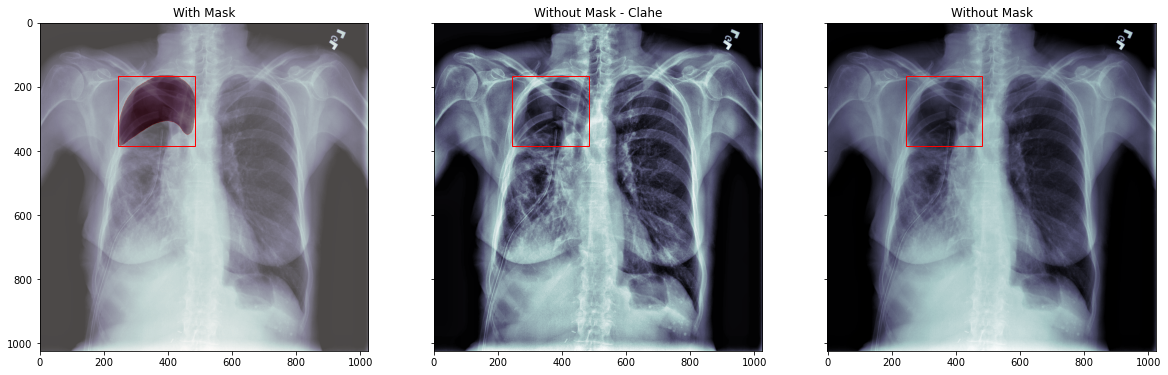

In [26]:
# lets take some random samples of x-rays with 
train_meta_sample = train_meta_df[train_meta_df['has_pneumothorax']==1].sample(n=3)
# plot ten xrays with and without mask
for index, row in train_meta_sample.iterrows():
    file_path = row['file_path']
    mask_encoded_list = row['encoded_pixels_list']
    print('image id: ' + row['id'])
    plot_with_mask_and_bbox(file_path, mask_encoded_list)

In [27]:
# print missing annotation
missing_vals = train_meta_df[train_meta_df['encoded_pixels_count']==0]['encoded_pixels_count'].count()
print("Number of x-rays with missing labels: {}".format(missing_vals))

Number of x-rays with missing labels: 42


In [28]:
tr_fol = glob(r'../input/siim-train-test-2/dicom-images-test/*/*/*')
tr_df = pd.read_csv(r'../input/siim-train-test-2/train-rle.csv', index_col='ImageId')

In [29]:
tr_df.head()

EncodedPixels
ImageId                                                                                              
1.2.276.0.7230010.3.1.4.8323329.6904.1517875201...                                                 -1
1.2.276.0.7230010.3.1.4.8323329.13666.151787524...  557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
1.2.276.0.7230010.3.1.4.8323329.11028.151787522...                                                 -1
1.2.276.0.7230010.3.1.4.8323329.10366.151787522...  514175 10 1008 29 994 30 993 32 991 33 990 34 ...
1.2.276.0.7230010.3.1.4.8323329.10016.151787522...  592184 33 976 58 956 73 941 88 926 102 917 109...

In [30]:
Attrs = ['ViewPosition', 'PatientAge', 'PatientSex']
Width, Height = 1024, 1024

def readMetaData(Folders, DF=pd.DataFrame()):
    missing = []
    for Fol in Folders:
        Sub = glob(Fol+'/*')
        File = glob(Sub[0]+'/*.dcm')[0]
        ID = File.split('/')[-1][:-4]
        try:
            DCM = dcm.dcmread(File)
            for atr in Attrs:
                DF.loc[ID, atr] = getattr(DCM, atr)
            Im = DCM.pixel_array
            for i, Part in enumerate([Im, 
                            Im[:512, :512], 
 Im[:512, 512:], 
                            Im[512:, :512], 
                            Im[512:, 512:]]):
                DF.loc[ID, 'ImageMean_%d'%i] = Part.mean()
                DF.loc[ID, 'ImageStd_%d'%i] = Part.std()
        except Exception:
            missing.append(File)
    return DF, missing

In [31]:
"This function converts Run Length encodings to masks"

'''

Args:
        rle : run length encoding values
        width: width of the output image
        height : height of the output image 
        
    Returns:
        plots the image with and without mask.
        
'''

def rle2mask(rle, width=Width, height=Height):
    mask= np.zeros(width* height)
    if rle == '-1' or rle == ' -1':
        return mask.reshape(width, height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [32]:
tr_df.rename(columns={' EncodedPixels':'EncodedPixels'}, inplace=True)
tr_df['PneumMask'] = tr_df.EncodedPixels.apply(rle2mask)
tr_df['PneumSize'] = tr_df.PneumMask.apply(lambda mask: len(np.where(mask>0)[0]))
tr_df['PneumSizeLog'] = tr_df.PneumSize.apply(np.log1p)
tr_df.dropna(inplace=True)

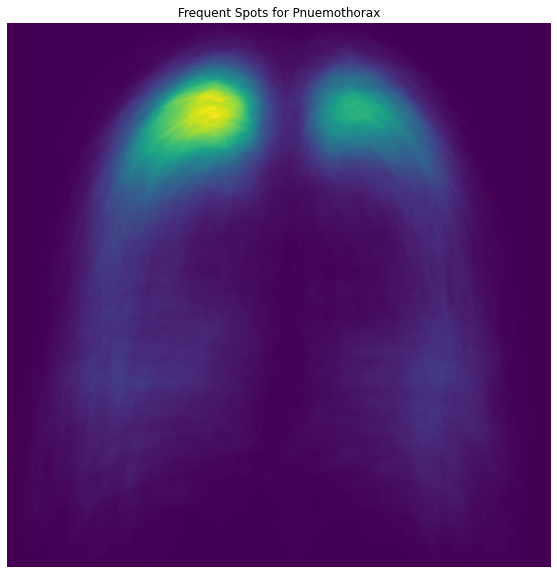

In [33]:
Mask_freq = np.mean(tr_df[tr_df.PneumSize > 0].PneumMask.values, 0)
Mask_freq /= 255  # when the pixel is present in the mask, its value is 255
# It is the probability of being in the mask if the patient is diagnosed with Pneumothorax.

pl.figure(figsize=(10,10))
pl.imshow(Mask_freq.T);
pl.title('Frequent Spots for Pnuemothorax')
pl.axis('off');

In [34]:
"This function plots the area affected with Pneumothorax"

'''

Args:
        encoded pixels list : list of encoded pixel values
        pixel spacing : spacing between two pixels  
        
    Returns:
            Area affected with Pneumothorax
        
'''

def get_affected_area(encoded_pixels_list, pixel_spacing):
    
    # take the encoded mask, decode, and get the sum of nonzero elements
    pixel_sum = 0
    
    for encoded_mask in encoded_pixels_list:
        mask_decoded = rle2mask(encoded_mask, 1024, 1024).T
        pixel_sum += np.count_nonzero(mask_decoded)
        
    area_per_pixel = pixel_spacing[0] * pixel_spacing[1]
    
    return pixel_sum * area_per_pixel

In [35]:
# create a subset of dataframe for pneumothorax patients
pneumothorax_df = train_meta_df[train_meta_df['has_pneumothorax']==1].copy()
# get sum of non zero elements in mask
pneumothorax_df['pneumothorax_area'] = pneumothorax_df.apply(lambda row: 
                                    get_affected_area(row['encoded_pixels_list'], row['pixel_spacing']),axis=1)

In [36]:
pneumothorax_df_m = pneumothorax_df[pneumothorax_df['patient_sex']=='M']
pneumothorax_df_f = pneumothorax_df[pneumothorax_df['patient_sex']=='F']
pneumo_size_m = pneumothorax_df_m['pneumothorax_area'].values
pneumo_size_f = pneumothorax_df_f['pneumothorax_area'].values

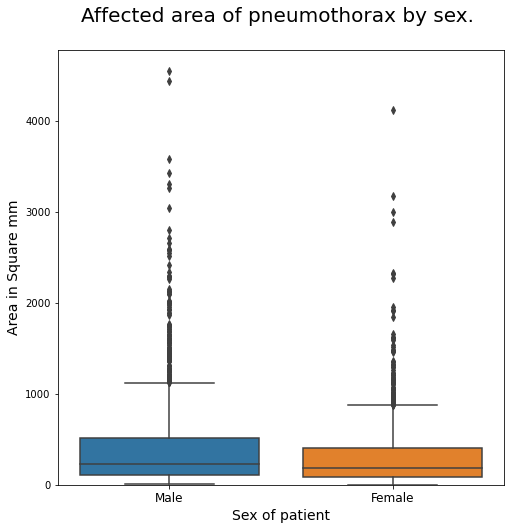

In [37]:
data = [pneumo_size_m, pneumo_size_f]
tick =[0,1]
x_labels = ['Male', "Female"]
fig = plt.figure(figsize = (8, 8))
ax = sns.boxplot(data =data)
plt.xlabel("Sex of patient", fontsize = 14)
plt.ylabel('Area in Square mm', fontsize = 14)
plt.title("Affected area of pneumothorax by sex. \n", fontsize = 20)
plt.xticks(tick, x_labels, fontsize = 12)
plt.ylim(0,)
plt.show()